# Wrangling Data From Bay Area Bike Share Published Data - Bikes

### Import Packages

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime
import math
import numpy as np

import seaborn as sns
sns.set()

<p> Set some notebook variables, makes the notebook 95% width of the screen for easier viewing</p>

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

<p> Set some global font sizes for plots </p>

In [3]:
font = {'size'   : 50}
matplotlib.rc('font', **font)

LABEL_FONT_SIZE = 15
TITLE_FONT_SIZE = 25

## Import Data

In [4]:
print('Started Loading Trips Data...')
file_path_slug = '../../clean_data/bayareabikeshare/trip_data_extended_cleaned_20*.csv'
file_list = glob(file_path_slug)

trips_df = pd.DataFrame()

counter = 1
chunks = []

for file in file_list:
    
    chunk_counter = 1
    num_chunks = math.ceil(sum(1 for row in open(file, 'r'))/10000)
    
    for chunk in pd.read_csv(file, chunksize=10000, iterator=True, index_col=0):
        # append chunk to chunks list
        chunks.append(chunk)

        if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
            print('\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
        chunk_counter += 1
        
    print('Finished file! (%d of %d)' % (counter, len(file_list)))
    counter += 1
    
trips_df = pd.concat(chunks)
trips_df.reset_index(inplace=True, drop=True)
print('Data Loaded Successfully!')

Started Loading Trips Data...
	[15:39:58.007795] finished chunk 1 of 22
	[15:39:58.388083] finished chunk 3 of 22
	[15:39:58.931956] finished chunk 6 of 22
	[15:39:59.504875] finished chunk 9 of 22
	[15:40:00.034641] finished chunk 12 of 22
	[15:40:00.575799] finished chunk 15 of 22
	[15:40:01.116493] finished chunk 18 of 22
	[15:40:01.689021] finished chunk 21 of 22
	[15:40:01.700547] finished chunk 22 of 22
Finished file! (1 of 4)
	[15:40:03.082119] finished chunk 1 of 35
	[15:40:03.631823] finished chunk 4 of 35
	[15:40:04.335808] finished chunk 8 of 35
	[15:40:05.041614] finished chunk 12 of 35
	[15:40:05.751769] finished chunk 16 of 35
	[15:40:06.446552] finished chunk 20 of 35
	[15:40:07.168395] finished chunk 24 of 35
	[15:40:07.862237] finished chunk 28 of 35
	[15:40:08.561238] finished chunk 32 of 35
	[15:40:09.009962] finished chunk 35 of 35
Finished file! (2 of 4)
	[15:40:10.327064] finished chunk 1 of 33
	[15:40:10.835989] finished chunk 4 of 33
	[15:40:11.843189] finished 

In [5]:
trips_df.iloc[0,:].transpose()

trip_id                                                                 1049878
duration                                                                   1078
start_date                                                  2016-01-01 00:01:00
start_station_id                                                             70
end_date                                                    2016-01-01 00:19:00
end_station_id                                                               55
bike_id                                                                     451
user_type                                                            Subscriber
user_zip                                                                  95113
duration_minutes                                                        17.9667
start_station_name                     San Francisco Caltrain (Townsend at 4th)
start_station_region                                              San Francisco
start_station_elevation_meters          

# Isolate Bike Data
<p>Each Trip Recorded inclues the bike_id, extract data we need for this smaller dataset</p>

In [6]:
bike_df = pd.DataFrame()
bike_df['first_trip'] = pd.to_datetime(trips_df.groupby('bike_id')['start_date'].min())
bike_df['latest_trip']  = pd.to_datetime(trips_df.groupby('bike_id')['start_date'].max())
bike_df['trip_count'] = trips_df.groupby('bike_id')['start_date'].count()
bike_df['trip_count'] = trips_df.groupby('bike_id')['start_date'].count()
bike_df['elevation_change'] = trips_df.groupby('bike_id')['elevation_change_feet'].sum()

bike_df['days_in_service'] = (bike_df['latest_trip'] - bike_df['first_trip']).dt.days

last_recorded_trip = bike_df.latest_trip.max()
bike_df['days_since_last_trip'] = (last_recorded_trip - bike_df.latest_trip).dt.days

last_recorded_trip = bike_df.latest_trip.max()
bike_df['bike_age'] = (last_recorded_trip - bike_df.first_trip).dt.days

bike_df['total_usage_time'] = trips_df.groupby('bike_id')['duration'].sum()
bike_df['median_usage_time_per_trip'] = trips_df.groupby('bike_id')['duration'].median()
bike_df['mean_usage_time_per_trip'] = trips_df.groupby('bike_id')['duration'].mean()
bike_df['mean_rides_per_day'] = bike_df['trip_count'] / bike_df['days_in_service']

# count number of unique stations visitied by each bike
bike_df['unique_start_stations'] = 0
bike_df['unique_end_stations'] = 0

# count number of unique routes by each bike
bike_df['unique_routes'] = 0



bike_df.head()

,first_trip,latest_trip,trip_count,elevation_change,days_in_service,days_since_last_trip,bike_age,total_usage_time,median_usage_time_per_trip,mean_usage_time_per_trip,mean_rides_per_day,unique_start_stations,unique_end_stations,unique_routes
bike_id,,,,,,,,,,,,,,
9,2013-08-29 12:02:00,2016-08-21 18:52:00,421,181.457088,1088,10,1098,540930,450.0,1284.869359,0.386949,0,0,0
10,2013-09-01 13:47:00,2016-08-31 16:53:00,380,185.329427,1095,0,1095,663901,365.0,1747.107895,0.347032,0,0,0
11,2013-08-29 20:11:00,2016-08-28 09:35:00,266,13.856805,1094,3,1098,285647,420.0,1073.860902,0.243144,0,0,0
12,2013-08-30 17:15:00,2016-08-31 17:25:00,359,9.710017,1097,0,1097,524928,344.0,1462.194986,0.327256,0,0,0
13,2013-08-29 10:13:00,2016-08-30 11:01:00,344,135.428650,1097,1,1098,592022,329.5,1720.994186,0.313582,0,0,0


# Count of Unique Stations visitied by each Bike

In [7]:
for i, bid in enumerate(bike_df.index):
    
    df = pd.DataFrame()
    df = trips_df[trips_df.bike_id == bid].copy()
    
    # count unique start and end station_ids
    unique_start_stations = len(sorted(pd.unique(df.start_station_id)))
    unique_end_stations   = len(sorted(pd.unique(df.end_station_id)))
    
    # count unique routes
    unique_routes = df.groupby(['start_station_id', 'end_station_id']).count()['bike_id']
    
    
    bike_df.iloc[i,-3] = unique_start_stations
    bike_df.iloc[i,-2] = unique_end_stations
    bike_df.iloc[i,-1] = unique_routes.shape[0]
    
bike_df.head()

,first_trip,latest_trip,trip_count,elevation_change,days_in_service,days_since_last_trip,bike_age,total_usage_time,median_usage_time_per_trip,mean_usage_time_per_trip,mean_rides_per_day,unique_start_stations,unique_end_stations,unique_routes
bike_id,,,,,,,,,,,,,,
9,2013-08-29 12:02:00,2016-08-21 18:52:00,421,181.457088,1088,10,1098,540930,450.0,1284.869359,0.386949,58,57,184
10,2013-09-01 13:47:00,2016-08-31 16:53:00,380,185.329427,1095,0,1095,663901,365.0,1747.107895,0.347032,30,31,140
11,2013-08-29 20:11:00,2016-08-28 09:35:00,266,13.856805,1094,3,1098,285647,420.0,1073.860902,0.243144,31,28,126
12,2013-08-30 17:15:00,2016-08-31 17:25:00,359,9.710017,1097,0,1097,524928,344.0,1462.194986,0.327256,32,31,129
13,2013-08-29 10:13:00,2016-08-30 11:01:00,344,135.428650,1097,1,1098,592022,329.5,1720.994186,0.313582,29,27,86


# Count of Trips within each Region for each Bike

In [8]:
regions = list(trips_df.start_station_region.unique())
regions

['San Francisco', 'San Jose', 'Mountain View', 'Palo Alto', 'Redwood City']

In [9]:
bike_df['san_francisco_trips'] = 0
bike_df['san_jose_trips'] = 0
bike_df['mountain_view_trips'] = 0
bike_df['palo_alto_trips'] = 0
bike_df['redwood_city_trips'] = 0
bike_df['cross_region_trips'] = 0

bike_df.head(5)

,first_trip,latest_trip,trip_count,elevation_change,days_in_service,days_since_last_trip,bike_age,total_usage_time,median_usage_time_per_trip,mean_usage_time_per_trip,mean_rides_per_day,unique_start_stations,unique_end_stations,unique_routes,san_francisco_trips,san_jose_trips,mountain_view_trips,palo_alto_trips,redwood_city_trips,cross_region_trips
bike_id,,,,,,,,,,,,,,,,,,,,
9,2013-08-29 12:02:00,2016-08-21 18:52:00,421,181.457088,1088,10,1098,540930,450.0,1284.869359,0.386949,58,57,184,0,0,0,0,0,0
10,2013-09-01 13:47:00,2016-08-31 16:53:00,380,185.329427,1095,0,1095,663901,365.0,1747.107895,0.347032,30,31,140,0,0,0,0,0,0
11,2013-08-29 20:11:00,2016-08-28 09:35:00,266,13.856805,1094,3,1098,285647,420.0,1073.860902,0.243144,31,28,126,0,0,0,0,0,0
12,2013-08-30 17:15:00,2016-08-31 17:25:00,359,9.710017,1097,0,1097,524928,344.0,1462.194986,0.327256,32,31,129,0,0,0,0,0,0
13,2013-08-29 10:13:00,2016-08-30 11:01:00,344,135.428650,1097,1,1098,592022,329.5,1720.994186,0.313582,29,27,86,0,0,0,0,0,0


In [10]:
for i, bid in enumerate(bike_df.index):
    
    df = pd.DataFrame()
    df = trips_df[trips_df.bike_id == bid].copy()
    
    sf_trips = df[(df.start_station_region == 'San Francisco') &
                  (df.end_station_region == 'San Francisco')].shape[0]
    
    sj_trips = df[(df.start_station_region == 'San Jose') &
                  (df.end_station_region == 'San Jose')].shape[0]

    mv_trips = df[(df.start_station_region == 'Mountain View') &
                  (df.end_station_region == 'Mountain View')].shape[0]

    pa_trips = df[(df.start_station_region == 'Palo Alto') &
                  (df.end_station_region == 'Palo Alto')].shape[0]

    rc_trips = df[(df.start_station_region == 'Redwood City') &
                  (df.end_station_region == 'Redwood City')].shape[0]

    cross_region_trips = df[df.start_station_region != df.end_station_region].shape[0]
    
    bike_df.iloc[i,-6] = sf_trips
    bike_df.iloc[i,-5] = sj_trips
    bike_df.iloc[i,-4] = mv_trips
    bike_df.iloc[i,-3] = pa_trips
    bike_df.iloc[i,-2] = rc_trips
    bike_df.iloc[i,-1] = cross_region_trips
    
bike_df.head()

,first_trip,latest_trip,trip_count,elevation_change,days_in_service,days_since_last_trip,bike_age,total_usage_time,median_usage_time_per_trip,mean_usage_time_per_trip,mean_rides_per_day,unique_start_stations,unique_end_stations,unique_routes,san_francisco_trips,san_jose_trips,mountain_view_trips,palo_alto_trips,redwood_city_trips,cross_region_trips
bike_id,,,,,,,,,,,,,,,,,,,,
9,2013-08-29 12:02:00,2016-08-21 18:52:00,421,181.457088,1088,10,1098,540930,450.0,1284.869359,0.386949,58,57,184,75,169,113,61,2,1
10,2013-09-01 13:47:00,2016-08-31 16:53:00,380,185.329427,1095,0,1095,663901,365.0,1747.107895,0.347032,30,31,140,0,167,155,53,4,1
11,2013-08-29 20:11:00,2016-08-28 09:35:00,266,13.856805,1094,3,1098,285647,420.0,1073.860902,0.243144,31,28,126,0,210,18,14,23,1
12,2013-08-30 17:15:00,2016-08-31 17:25:00,359,9.710017,1097,0,1097,524928,344.0,1462.194986,0.327256,32,31,129,0,111,167,61,6,14
13,2013-08-29 10:13:00,2016-08-30 11:01:00,344,135.428650,1097,1,1098,592022,329.5,1720.994186,0.313582,29,27,86,0,30,251,40,14,9


***
# EDA Preview and Quick Reference

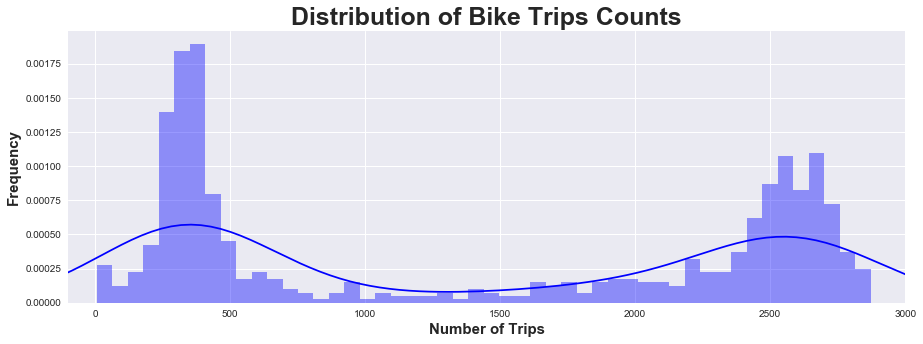

In [11]:
plt.subplots(figsize=(15,5))
sns.distplot(bike_df.trip_count, color='b', bins=50)
plt.title('Distribution of Bike Trips Counts', size=TITLE_FONT_SIZE, weight='bold')
plt.xlim(-100, 3000)
plt.xlabel('Number of Trips', size=LABEL_FONT_SIZE, weight='bold')
plt.ylabel('Frequency', size=LABEL_FONT_SIZE, weight='bold')
plt.show()

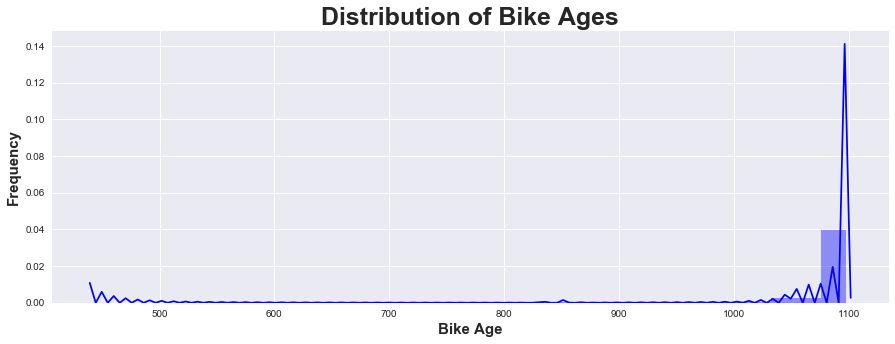

In [12]:
plt.subplots(figsize=(15,5))
sns.distplot(bike_df.bike_age, color='b', bins=30)
plt.title('Distribution of Bike Ages', size=TITLE_FONT_SIZE, weight='bold')
plt.xlabel('Bike Age', size=LABEL_FONT_SIZE, weight='bold')
plt.ylabel('Frequency', size=LABEL_FONT_SIZE, weight='bold')
plt.show()
plt.close()

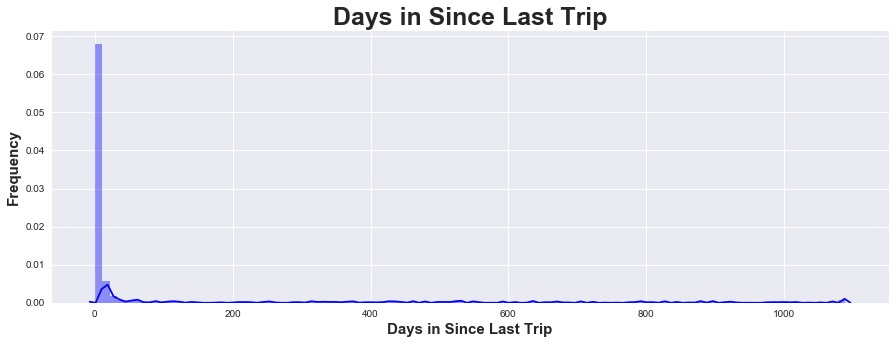

In [13]:
plt.subplots(figsize=(15,5))
sns.distplot(bike_df.days_since_last_trip, color='b', bins=100)
plt.title('Days in Since Last Trip', size=TITLE_FONT_SIZE, weight='bold')
plt.xlabel('Days in Since Last Trip', size=LABEL_FONT_SIZE, weight='bold')
plt.ylabel('Frequency', size=LABEL_FONT_SIZE, weight='bold')
plt.show()
plt.close()

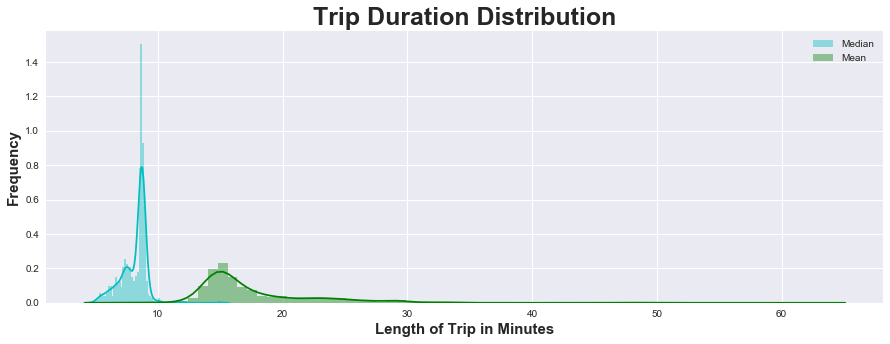

In [ ]:
plt.subplots(figsize=(15,5))
ax = sns.distplot(bike_df.median_usage_time_per_trip/60., color='c', bins=70)
sns.distplot(bike_df.mean_usage_time_per_trip/60., color='g', bins=70, ax=ax)
plt.title('Trip Duration Distribution', size=TITLE_FONT_SIZE, weight='bold')
plt.xlabel('Length of Trip in Minutes', size=LABEL_FONT_SIZE, weight='bold')
plt.ylabel('Frequency', size=LABEL_FONT_SIZE, weight='bold')
plt.legend(['Median', 'Mean'], loc='best')
plt.show()
plt.close()

In [ ]:
for bid in sorted(bike_df.index):
    bike_trips = pd.DataFrame()
    bike_trips = trips_df[trips_df.bike_id == bid].copy()
    bike_trips.start_date = pd.to_datetime(bike_trips.start_date)
    bike_trips.groupby(bike_trips.start_date.dt.time).mean()['duration_minutes'].plot(figsize=(24,6), alpha=0.75, linestyle='', marker='.')

# trip count per day
plt.xlabel('Date')
plt.ylabel('Trip Count')
plt.show()
plt.close()

In [ ]:
bike_df.describe()

# Write to File

In [ ]:
bike_df.to_csv('../../clean_data/bayareabikeshare/bike_data_cleaned.csv', encoding='utf-8')